In [1]:
!pip install torch torchvision scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.2 MB/s eta 0:00:00


100%|██████████| 169M/169M [00:03<00:00, 48.2MB/s]



--- Geração 1 ---
Acurácia: 0.0150 {'learning_rate': 0.0005, 'batch_size': 8, 'n_filters': 16, 'n_fc': 16, 'dropout': 0.25} | Tempo: 12.8s
Acurácia: 0.0150 {'learning_rate': 0.0005, 'batch_size': 16, 'n_filters': 8, 'n_fc': 16, 'dropout': 0.25} | Tempo: 5.8s
Acurácia: 0.0120 {'learning_rate': 0.001, 'batch_size': 8, 'n_filters': 16, 'n_fc': 16, 'dropout': 0.5} | Tempo: 11.6s
Acurácia: 0.0070 {'learning_rate': 0.001, 'batch_size': 8, 'n_filters': 16, 'n_fc': 8, 'dropout': 0.25} | Tempo: 10.7s
Acurácia: 0.0180 {'learning_rate': 0.0005, 'batch_size': 16, 'n_filters': 8, 'n_fc': 8, 'dropout': 0.25} | Tempo: 5.0s
Acurácia: 0.0110 {'learning_rate': 0.0005, 'batch_size': 8, 'n_filters': 16, 'n_fc': 16, 'dropout': 0.5} | Tempo: 11.3s
Acurácia: 0.0130 {'learning_rate': 0.0005, 'batch_size': 16, 'n_filters': 16, 'n_fc': 16, 'dropout': 0.25} | Tempo: 10.2s
Acurácia: 0.0180 {'learning_rate': 0.0005, 'batch_size': 8, 'n_filters': 8, 'n_fc': 16, 'dropout': 0.25} | Tempo: 7.2s
Acurácia: 0.0110 {'lea

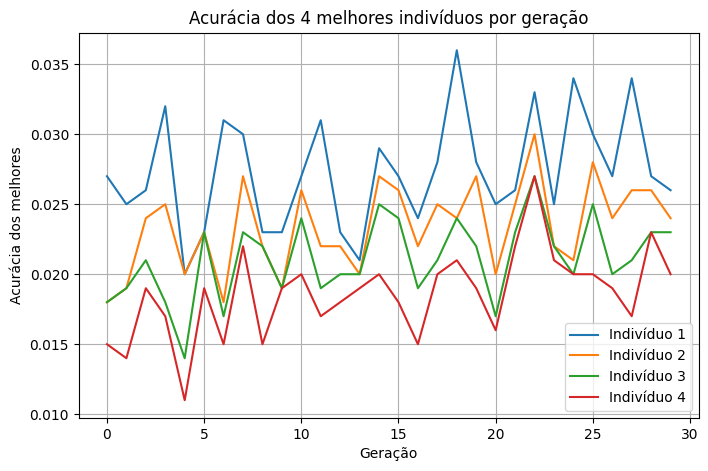


5 exemplos que o algoritmo ACERTOU:


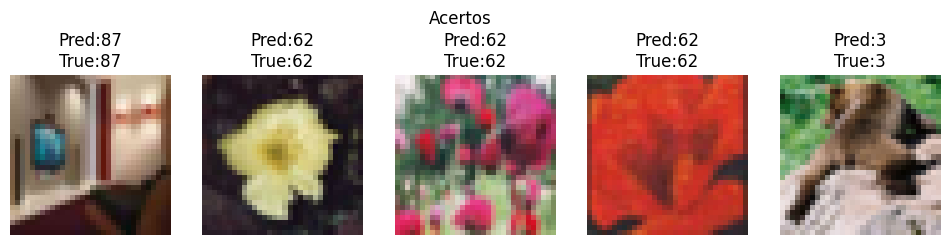


5 exemplos que o algoritmo ERROU:


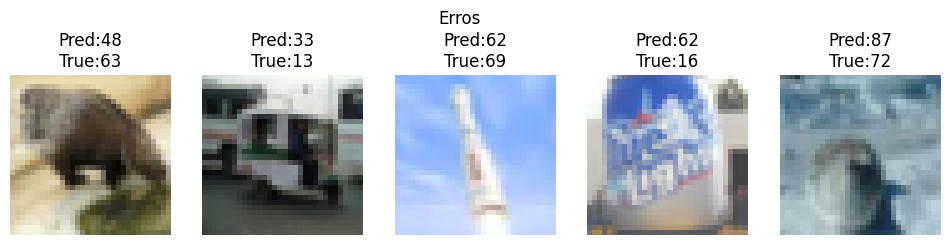

In [2]:
# Requisitos para Colab:
# !pip install torch torchvision scikit-learn matplotlib -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# ========================
# 1. Espaço de Hiperparâmetros
# ========================
space = {
    "learning_rate": [1e-3, 5e-4],
    "batch_size": [8, 16],
    "n_filters": [8, 16],
    "n_fc": [8, 16],
    "dropout": [0.25, 0.5]
}

# ========================
# 2. Dataset CIFAR-100
# ========================
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    full_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    train_idx, val_idx = train_test_split(range(len(full_trainset)), test_size=0.2, random_state=42)
    trainset = Subset(full_trainset, train_idx[:4000])
    valset = Subset(full_trainset, val_idx[:1000])
    # Para mostrar imagens depois
    full_valset = Subset(full_trainset, val_idx)
    return trainset, valset, full_valset

trainset, valset, full_valset = load_data()

# ========================
# 3. CNN Simples com Flatten Dinâmico
# ========================
class SmallCNN(nn.Module):
    def __init__(self, n_filters, n_fc, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters * 2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.n_fc = n_fc
        self.flatten_dim = None
        self.fc1 = None
        self.fc2 = None

    def build(self, device):
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32).to(device)
            x = torch.relu(self.conv1(x))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.dropout(x)
            self.flatten_dim = x.view(1, -1).shape[1]
        self.fc1 = nn.Linear(self.flatten_dim, self.n_fc).to(device)
        self.fc2 = nn.Linear(self.n_fc, 100).to(device)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        if self.fc1 is None or self.fc2 is None:
            raise ValueError("Chame o método build(device) após instanciar o modelo!")
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ========================
# 4. Funções do AG e Avaliação
# ========================
def criar_individuo():
    return {
        "learning_rate": random.choice(space["learning_rate"]),
        "batch_size": random.choice(space["batch_size"]),
        "n_filters": random.choice(space["n_filters"]),
        "n_fc": random.choice(space["n_fc"]),
        "dropout": random.choice(space["dropout"]),
    }

def crossover(pai1, pai2):
    filho = {}
    for key in pai1:
        filho[key] = random.choice([pai1[key], pai2[key]])
    return filho

def mutar(individuo):
    chave = random.choice(list(space.keys()))
    individuo[chave] = random.choice(space[chave])
    return individuo

def avaliar_fitness(individuo, device, save_preds=False):
    # DataLoaders
    train_loader = DataLoader(trainset, batch_size=individuo["batch_size"], shuffle=True, num_workers=2)
    val_loader = DataLoader(valset, batch_size=individuo["batch_size"], shuffle=False, num_workers=2)

    # Modelo, loss, optimizer
    model = SmallCNN(
        n_filters=individuo["n_filters"],
        n_fc=individuo["n_fc"],
        dropout=individuo["dropout"]
    ).to(device)
    model.build(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=individuo["learning_rate"])

    # Treinamento curto (1 época)
    model.train()
    for epoch in range(1):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    # Validação
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            _, predicted = torch.max(pred, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    acc = correct / total

    if save_preds:
        return acc, np.array(all_preds), np.array(all_labels)
    return acc

# ========================
# 5. AG Modular com Coleta de Estatísticas
# ========================
def algoritmo_genetico(pop_size=4, geracoes=3, taxa_mutacao=0.3, device='cpu'):
    historico = []
    tempo_inicio = time.time()
    populacao = [criar_individuo() for _ in range(pop_size)]

    for g in range(geracoes):
        print(f"\n--- Geração {g+1} ---")
        fitness = []
        for ind in populacao:
            start = time.time()
            acc = avaliar_fitness(ind, device)
            elapsed = time.time() - start
            fitness.append(acc)
            print(f"Acurácia: {acc:.4f} {ind} | Tempo: {elapsed:.1f}s")

        # Salva histórico dos 4 melhores da geração
        melhores = sorted(zip(populacao, fitness), key=lambda x: x[1], reverse=True)
        historico.append([fit for _, fit in melhores[:4]])
        for i, (ind, fit) in enumerate(melhores[:4]):
            print(f"{i+1}: Acc = {fit:.4f}, {ind}")

        selecionados = [ind for ind, _ in melhores[:pop_size // 2]]
        nova_populacao = selecionados[:]
        while len(nova_populacao) < pop_size:
            pai1, pai2 = random.sample(selecionados, 2)
            filho = crossover(pai1, pai2)
            if random.random() < taxa_mutacao:
                filho = mutar(filho)
            nova_populacao.append(filho)
        populacao = nova_populacao

    # Melhor resultado final (com predição para análise)
    final_fitness = []
    for ind in populacao:
        acc = avaliar_fitness(ind, device)
        final_fitness.append(acc)
    melhor_indice = final_fitness.index(max(final_fitness))
    melhor_ind = populacao[melhor_indice]
    acc, preds, labels = avaliar_fitness(melhor_ind, device, save_preds=True)
    tempo_total = time.time() - tempo_inicio

    return melhor_ind, acc, preds, labels, historico, tempo_total

# ========================
# 6. Funções de Relatório e Visualização
# ========================
def plot_accuracies(historico):
    plt.figure(figsize=(8, 5))
    for i in range(len(historico[0])):  # 4 melhores
        plt.plot([h[i] for h in historico], label=f"Indivíduo {i+1}")
    plt.xlabel("Geração")
    plt.ylabel("Acurácia dos melhores")
    plt.title("Acurácia dos 4 melhores indivíduos por geração")
    plt.legend()
    plt.grid()
    plt.show()

def show_stats(historico, tempo_total, melhor_ind, acc):
    print("\n========== RELATÓRIO FINAL ==========")
    print(f"Tempo total de execução: {tempo_total:.1f} segundos")
    print(f"Melhor indivíduo final: {melhor_ind}")
    print(f"Acurácia do melhor: {acc:.4f}")
    acuracias = [acc for hist in historico for acc in hist]
    print(f"Acurácia média (todas): {np.mean(acuracias):.4f}")
    print(f"Acurácia máxima (histórico): {np.max(acuracias):.4f}")
    print(f"Acurácia mínima (histórico): {np.min(acuracias):.4f}")

def plot_image_examples(full_valset, preds, labels, acertos=True, n=5):
    import matplotlib.pyplot as plt
    idxs = np.where((preds == labels) if acertos else (preds != labels))[0][:n]
    if len(idxs) == 0:
        print("Nenhum exemplo encontrado.")
        return
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(idxs):
        img, label = full_valset[idx]
        img = img.permute(1,2,0) * torch.tensor([0.2675, 0.2565, 0.2761]) + torch.tensor([0.5071, 0.4867, 0.4408])
        img = img.numpy().clip(0,1)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Pred:{preds[idx]}\nTrue:{labels[idx]}")
        plt.axis('off')
    plt.suptitle("Acertos" if acertos else "Erros")
    plt.show()

# ========================
# 7. Execução Modular e Relatório
# ========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
melhor_ind, acc, preds, labels, historico, tempo_total = algoritmo_genetico(
    pop_size=10, geracoes=30, taxa_mutacao=0.3, device=device
)
show_stats(historico, tempo_total, melhor_ind, acc)
plot_accuracies(historico)
print("\n5 exemplos que o algoritmo ACERTOU:")
plot_image_examples(full_valset, preds, labels, acertos=True, n=5)
print("\n5 exemplos que o algoritmo ERROU:")
plot_image_examples(full_valset, preds, labels, acertos=False, n=5)
